> # Neural Network Basic - Week3 과제


## Import Library

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from mnist import load_mnist

## Load Dataset
- MNIST 

In [14]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [15]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [25]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        output = 1/(1+np.exp(-x))
        return output
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        output = 1/(1+np.exp(-x))
        return output * (1- output)

In [26]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        if x > 0:
            output = x;
        elif x <= 0:
            output = 0;            
        return output
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        if x > 0:
            output = 1;
        elif x <= 0:
            output = 0;  
        return output

In [27]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [28]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [29]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [30]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr                                         #가중치 업데이트 학습률(step size)
        self.epoch = epoch                                   #모델이 학습을 반복할 횟수
        self.batch_size = batch_size                         #batch의 크기
        self.loss_function = cross_entropy                   #모델 성능평가에 사용되는 Loss function
        self.layers = []                                     #Layer 배열
        self.activations = [softmax]                         #활성함수 배열
        self.nodes = []                                      #노드배열
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer)                            #layer를 입력받아 배열에 추가한다.
        if not self.nodes:                                  #node가 비어있을 시에
            self.nodes.append(np.zeros(Layer.input_size))   #input size에 대한 정보 추가
        self.nodes.append(np.zeros(Layer.output_size))      #output노드들의 size를 포함하여 노드를 추가한다.
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop()                        #기존 마지막단의 활성함수 추출
        self.activations.append(Activation)                 #새로운 활성함수 추가
        self.activations.append(tmp)                        #추출해둔 마지막단의 활성함수 추가
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy()                            #입력 X로 첫단 대체
        output = X.copy()                                   
        for i in range(len(self.layers)): 
            Layer = self.layers[i]                          
            Activation = self.activations[i]                #layer별 활성함수 지정
            output = np.dot(self.nodes[i], Layer.weight)    #Node 값과 가중치 값을 행렬곱하여 출력
            output = output+ Layer.bias                     #윗 행의 코드 결과물에 bias 더함
            output = Activation.forward(output)             #활성함수 적용
            self.nodes[i+1] = output                        #다음번 노드로 결과값 전달
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))):         #반대 방향으로 진행
            a = self.nodes[i+1]                               
            Layer = self.layers[i]                             
            Activation = self.activations[i]         
            
            #은닉충 별로 error 계산
            if i+1 == len(self.layers): 
                error = Activation.backward(output, y)      
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0]  #error 값과 learnrin rate를 이용하여 가중치 업데이트 
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]                   #바이어스 업데이트
            error = np.dot(error, Layer.weight.T)                                #Error 값 계산
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1)                                        #Softmax 값이 가장 큰 index 변환
        return np.sum(pre_p==y)/y.shape[0]                                      #분류가 잘 된 비율
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch):
            for j in range(N//self.batch_size):                                 #미니배치 크기만큼 진행
                batch_mask = np.random.choice(N, self.batch_size)               #배치사이즈 만큼의 N개의 mask 선택
                X_batch = X[batch_mask]                                         
                y_batch = y[batch_mask]                               
                output = self._forward(X_batch)                                 #배치 데이터 순전파                   
                self._backward(X_batch, output, y_batch)                        #역전파
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [31]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [32]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [33]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23182.82763804966
10 test accuracy : 0.1141
10 test loss     : 22862.44169856714
20 test accuracy : 0.1756
20 test loss     : 22691.07019449911
30 test accuracy : 0.1747
30 test loss     : 22365.136687711125
40 test accuracy : 0.2561
40 test loss     : 21624.82191991981
50 test accuracy : 0.2589
50 test loss     : 20294.656226982825
60 test accuracy : 0.3075
60 test loss     : 18918.78570590689
70 test accuracy : 0.4195
70 test loss     : 17361.27042582381
80 test accuracy : 0.495
80 test loss     : 15171.329513057563
90 test accuracy : 0.5891
90 test loss     : 13141.121548241144
100 test accuracy : 0.6599
100 test loss     : 11448.806927739246
110 test accuracy : 0.7064
110 test loss     : 10119.699969965406
120 test accuracy : 0.7403
120 test loss     : 9103.069923562
130 test accuracy : 0.7635
130 test loss     : 8302.252335780211
140 test accuracy : 0.7881
140 test loss     : 7643.801221819511
150 test accuracy : 0.8086
150 test loss     

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

In [34]:
def get_accuracy(history, epoch):
    fig = plt.figure()
    ax_acc = fig.add_subplot(111)

    ax_acc.plot(range(epoch), history['val_acc'], label='정확도(%)', color='darkred')
    plt.xlabel('epochs')
    plt.ylabel('Validation Accuracy(%)')
    ax_acc.grid(linestyle='--', color='lavender')
    ax_loss = ax_acc.twinx()
    ax_loss.plot(range(epoch), history['val_loss'], label='오차', color='darkblue')
    plt.ylabel('Validation Loss')
    ax_loss.yaxis.tick_right()
    ax_loss.grid(linestyle='--', color='lavender')

    # 그래프 표시
    plt.show()
    print("Best Validation Accuracy : ",max(history['val_acc']))
    

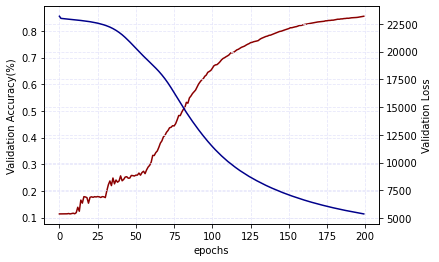

Best Validation Accuracy :  0.8548


In [37]:
get_accuracy(history, 200)